In [1]:
from scipy.signal import fftconvolve
import numpy as np
from matplotlib import pyplot as plt
import imageio

In [2]:
# Smiley helper functions pg1.
def left_eye(xy_mesh, off=True):
    """Uses meshgrid."""
    # Define eye region.
    x_offset = 0.35
    y_offset = -0.4
    vals = ((.125)**2 - ((xy_mesh[0] + x_offset)**2 + (xy_mesh[1] + y_offset)**2))
    mask = vals < 0
    # One level eye.
    vals[~mask] = .05
    # Zero other regions.
    vals[mask] = 0
    if off:
        vals[~mask] += 1
    return vals

def right_eye(xy_mesh, off=True):
    """Uses meshgrid."""
    # Define eye region.
    x_offset = -0.35
    y_offset = -0.4
    vals = ((.125)**2 - ((xy_mesh[0] + x_offset)**2 + (xy_mesh[1] + y_offset)**2))
    mask = vals < 0
    # One level eye.
    vals[~mask] = .05
    # Zero other regions.
    vals[mask] = 0
    if off:
        vals[~mask] += 1
    return vals


In [3]:
# Smiley helper functions pg2.
def smile1(xy_mesh, off=True):
    """An opened mouth smile.
    Uses meshgrid."""
    m,n = xy_mesh[0].shape
    # Define smile region.
    radius = 3.0/5
    vals = (radius)**2 - (xy_mesh[0]**2 + xy_mesh[1]**2)
    mask = vals < 0
    # Zero other regions.
    vals[mask] = 0
    if off:
        vals /= np.max(vals)
        vals[~mask] = 1
    else:
        # One level smile
        vals[~mask] = -0.05
    # Erase top half (which gets flipped when save file).
    vals[m//2:] = 0
    return vals

def smile2(xy_mesh, off=True):
    """A closed mouth smile.
    Uses meshgrid."""
    m,n = xy_mesh[0].shape
    outer_r = 2.0/3
    inner_r = 1.0/2
    # Create smile regions.
    circ = (xy_mesh[0])**2 + (xy_mesh[1])**2
    vals = (outer_r)**2 - circ
    novals = (inner_r)**2 - circ
    mask1 = vals < 0
    mask2 = novals < 0
    # Peak the center line of the smile.
    if off:
        vals[~mask2 + mask1] = 0
        mx = np.max(vals)
        # Peak values around smile line, values between [0, mx/2].
        vals = mx/2 - np.abs(vals - mx/2)
        # Normalize nonzero values between [0,1].
        vals /= np.max(vals)
        # Add one.
        vals[~mask] += 1
    else:
        # One level smile.
        vals[~mask1] = .05
    # Zero other regions.
    vals[~mask2 + mask1] = 0
    # Erase top half (which gets flipped when save file).
    vals[m//2:] = 0
    return vals

def smile3(xy_mesh, off=True):
    """Opened mouth smile with depth.
    Uses meshgrid."""
    m,n = xy_mesh[0].shape
    # Define smile region.
    radius = 3./5
    vals = (radius)**2 - (xy_mesh[0]**2 + xy_mesh[1]**2)
    mask = vals < 0
    # Zero other regions.
    vals[mask] = 0
    # Put values between [-.15, -.05]
    vals /= np.max(vals)*10
    vals[~mask] += 1/20
    vals *= -1
    # Zero bottom half (which gets flipped when save file).
    vals[m//2:] = 0
    return vals

In [4]:
# Smiley helper functions pg3.
def face1(xy_mesh, r):
    """A standard popout face outline. 
    Uses meshgrid."""
    outer_r = 23./20 * r
    inner_r = 19./20 * r
    edge_vals = ((outer_r)**2 - (xy_mesh[0]**2 + xy_mesh[1]**2))
    inner_vals = ((inner_r)**2 - (xy_mesh[0]**2 + xy_mesh[1]**2))
    mask1 = edge_vals < 0
    mask2 = inner_vals < 0
    edge_vals[~mask2 + mask1] = 0
    # Make the edge a ridge.
    mx = np.max(edge_vals)
#     edge_vals = (mx/2 - np.abs(edge_vals - mx/2))**0.8
    edge_vals = (mx/2 - np.abs(edge_vals - mx/2))**1.0
    # Normalize nonzero values between [0,0.1].
    edge_vals /= np.max(edge_vals)*10
#     edge_vals[edge_vals != 0] += 1
    return edge_vals

def face2(xy_mesh, r):
    """A standard one level face at radius r.
    Uses meshgrid."""
    # Define face region.
    vals = ((r)**2 - (xy_mesh[0]**2 + xy_mesh[1]**2))
    mask1 = vals < 0
    # Zero other regions.
    vals[mask1] = 0
    vals[~mask1] = .25
    return vals

def face_fuzzy(xy_mesh, r):
    """Best of face1 and face2. Edge rises to face.
    Uses [X,Y] meshgrid.
    """
    R = 1.1*r
    m,n = xy_mesh[0].shape
    # Define face regions.
    circ = (xy_mesh[0]**2 + xy_mesh[1]**2)
    Rvals = ((R)**2 - circ)
    rvals = ((r)**2 - circ)
    Rmask = Rvals < 0
    rmask = rvals < 0
    # Zero other regions.
    Rvals[Rmask + ~rmask] = 0
    Rvals /= np.max(Rvals)*4
    Rvals[~rmask] = .25
    # For separating from the background.
#     Rvals[Rvals != 0] += 1
    # For extending from the background.
#     Rvals[Rvals != 0] *=2
    return Rvals

def face3(xy_mesh, r):
    """A standard one level face at radius r.
    Uses meshgrid."""
    # Define face region.
    vals = ((r)**2 - (xy_mesh[0]**2 + xy_mesh[1]**2))
    mask1 = vals < 0
    # Zero other regions.
    vals[mask1] = 0
    vals /= np.max(vals)*8
    vals[~mask1] += 1/8
    return vals

In [5]:
# Smiley main function
def smiley_grad(smile=1, face_r=1, height=480):
    """Return arrays of smiley 1 or 2 using the radii R, r, at the given resolution.
    Returns the mesh (X,Y,Z) with smiley in Z"""
    zoom_factor = 1.3
    ratio = 4/3
    width = int(ratio * height)
    y_dist = zoom_factor * face_r
    x_dist = ratio * y_dist
    y = np.linspace(-y_dist, y_dist, height)
    x = np.linspace(-x_dist, x_dist, width)
    print(f'Resolution: ({height}, {width})')
    XY = np.meshgrid(x,y)
    # Check defined smileys.
    smiles = (1,2,3)
    if smile==1:
        Z = face2(XY, face_r) + smile1(XY, False) + left_eye(XY, False) + right_eye(XY, False)
    elif smile==2:
        Z = face2(XY, face_r) + smile2(XY, False) + left_eye(XY, False) + right_eye(XY, False)
    elif smile==3:
        Z = face3(XY, face_r) + smile3(XY, False) + left_eye(XY, False) + right_eye(XY, False)
    else:
        raise ValueError("Smile must be in {}".format(smiles))
    X, Y = XY
    Z *= 4
    return X, Y, Z

Resolution: (480, 640)


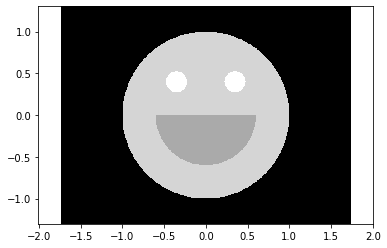

In [6]:
smi = 1
r = 1
height = 480
X,Y,Z = smiley_grad(smi, r, height)
smile = (Z / 2 * 255).astype(np.uint8)

write = False

if write:
    if smi == 1:
        imageio.imwrite('smiley1.png', smile[::-1])
    elif smi == 2:
        imageio.imwrite('smiley2.png', smile[::-1])
    elif smi == 3:
        imageio.imwrite('smiley1.png', smile[::-1])

plt.pcolormesh(X,Y,Z, cmap='gray')
plt.axis('equal')
plt.show()

In [7]:
# Helper function to saturn_depth().
def make_sphere(x_vals, y_vals, sphere_r, outer_r):
    """Make z values for sphere."""
    r_sqr_vals = x_vals**2 + y_vals**2
    z_vals = sphere_r**2 - r_sqr_vals
    mask_0 = z_vals < 0
    z_vals[mask_0] = 0
    z_vals = np.sqrt(z_vals)
    z_vals[~mask_0] += outer_r
    return z_vals

In [8]:
# Helper function to saturn_depth().
def make_ring(x_vals, y_vals, z_vals, inner_r, outer_r, min_maj_ratio):
    """Make z values for ring and superimpose on sphere."""
    # Get ellipsoid values.
    r_sqr_vals = x_vals**2 + (y_vals / min_maj_ratio)**2
    # Define area of ring.
    out_vals = outer_r**2 - r_sqr_vals
    in_vals = inner_r**2 - r_sqr_vals
    mask_out = out_vals < 0
    mask_in = in_vals < 0
    # Define values of inclined plane.
    ring_vals = -y_vals / min_maj_ratio
    # Ignore values behind the sphere.
    z_mask = z_vals > 0
    z_mask[:len(z_vals)//2] = False
    mask_out[z_mask] = True
    # Set ring values not behind sphere.
    z_vals[~(mask_out + ~mask_in)] = ring_vals[~(mask_out + ~mask_in)] + outer_r
    return z_vals

In [9]:
# Helper function to get_saturn().
def saturn_depth(x_vals, y_vals, sphere_r, inner_r, outer_r, min_maj_ratio):
    """Make z values for sphere and ring."""
    z_vals = make_sphere(x_vals, y_vals, sphere_r, outer_r)
    z_vals = make_ring(x_vals, y_vals, z_vals, inner_r, outer_r, min_maj_ratio)
    return z_vals

In [10]:
# Make depth map of Saturn.
def get_saturn(sphere_r=1, inner_r=1.5, outer_r=2, min_maj_ratio=.5, height=480):
    """Return depth map of Saturn."""
    zoom_factor = 2.
    ratio = 4/3
    width = int(ratio * height)
    y_dist = zoom_factor * sphere_r
    x_dist = ratio * y_dist
    y = np.linspace(-y_dist, y_dist, height)
    x = np.linspace(-x_dist, x_dist, width)
    print(f'Resolution: ({height}, {width})')
    x_vals, y_vals = np.meshgrid(x,y)
    
    z_vals = saturn_depth(x_vals, y_vals, sphere_r, inner_r, outer_r, min_maj_ratio)

    return x_vals, y_vals, z_vals

In [11]:
# What is the perceived distance?
# Consider an isosceles triangle where the base vertices are the eyes and the sides focus to a perceived point.
# The eyes can receive light from any point along the triangle edges.
# So the stereogram is made by forcing the eyes to focus closer, or making the triangle shorter.
# This is done by fixing the viewing distance, creating a trapezoid. Then the width of the top of the trapezoid
#  limits the height of the triangle. Infinite perception happens as the trapezoid tends to a rectangle. The minimum
#  distance is the height of the trapezoid as it tends to a triangle.
# Then the perceived distance d is a function of the fixed viewing distance f and the width of the trapezoid top
#  and bottom t and b.
# d = bf/(b-t)
# b-t = bf/d
# t = b - bf/d
# t = b(1 - f/d)
# The depth map is maxdepth-d, scaled to 256
# So distance should be viewing_distance + min_dist + var_dist*(max_depth - depth)

Resolution: (480, 640)


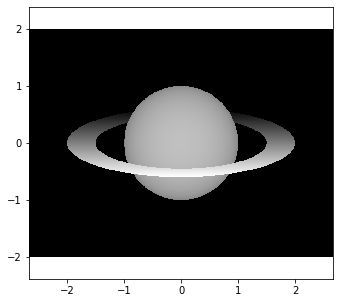

In [35]:
# Create Saturn depth map
sphere_r = 1
inner_r = 1.5
outer_r = 2
min_maj_ratio = .3
height = 480

X,Y,Z = get_saturn(sphere_r, inner_r, outer_r, min_maj_ratio, height)
saturn = (Z/np.max(Z) * 255).astype(np.uint8)

write = False
if write:
    imageio.imwrite('saturn.png', saturn[::-1])

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.pcolormesh(X,Y,Z, cmap='gray')
plt.axis('equal')
plt.show()